<a href="https://colab.research.google.com/github/Jarvis-X/Aerial-Robotics-Course-Projects/blob/main/CS498HW6MagicBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we import the libraries.

In [ ]:
try:
    import sim
    import numpy as np
    import time
    import matplotlib.pyplot as plt
except:
    print('--------------------------------------------------------------')
    print('Library loading failed!')
    print('')


Then create the Robot class. I changed the class name to be captalized to satisfy PEP8 convention.

I also modified `close_connection()` so that upon disconnection, the robot can stop actuating.

# BIG NOTE
I changed the LUA script in the scene file because the `sim.addForceAndTorque()` function applies the torque in the world frame. 
* For torque, the rotation happens w.r.t. the body frame.

Thus, instead of applying the transformation in the LUA script and applying its transpose in our python file, I just removed the transformation on the torque in the LUA script.

## Smaller note
* A helper function, `quat2rot(quat)` was implemented to convert the quaternion to the rotation matrix.

### An even smaller note
* I changed the data accquisition methods and `simxSetJointTargetVelocity` data sending method to `simx_opmode_streaming` which significantly improves the performance.


In [ ]:
class Robot:
    def __init__(self, frame_name, motor_names=[], client_id=0):
        # If there is an existing connection
        if client_id:
            self.client_id = client_id
        else:
            self.client_id = self.open_connection()

        self.motors = self._get_handlers(motor_names)

        # Robot frame
        self.frame = self._get_handler(frame_name)

    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

        if self.client_id != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return self.client_id

    def close_connection(self):
        self.wrench([0, 0, 0, 0, 0, 0])
        sim.simxGetPingTime(
            self.client_id)  # Before closing the connection of CoppeliaSim,
                             # make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection of CoppeliaSim:
        print('Connection closed')

    def is_connected(self):
        c, result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0

    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        if err_code != 0:
            print("ERROR: CANNOT GET HANDLER FOR OBJECT '{}'".format(name))
        return handler

    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)

        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id,
                                                      motor, vel, sim.simx_opmode_streaming)

            if err_code != 0:
                print("ERROR: CANNOT SET MOTOR {} WITH VELOCITY {}".format(motor, vel))

    def set_position(self, position, relative_object=-1):
        # By default, get the position wrt the reference frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        err_code = sim.simxSetObjectPosition(self.client_id, self.frame,
                                             relative_object, position, sim.simx_opmode_oneshot)
        if err_code != 0:
            print("ERROR: CANNOT SET POSITION W.R.T. {} TO {}".format(relative_object, position))

    def sim_time(self):
        return sim.simxGetLastCmdTime(self.client_id)

    def get_position(self, relative_object=-1):
        # Get position relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_streaming)
        return np.array(position)

    def get_orientation(self, relative_object=-1):
        # Get orientation relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, euler = sim.simxGetObjectOrientation(self.client_id, self.frame, relative_object, sim.simx_opmode_streaming)
        return np.array(euler)

    def get_quaternion(self, relative_object=-1):
        # Get orientation in quaternion relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, quat = sim.simxGetObjectQuaternion(self.client_id, self.frame, relative_object, sim.simx_opmode_streaming)
        return np.array(quat)

    def get_velocity(self, relative_object=-1):
        # Get velocity relative to an object, -1 for global frame
        if relative_object != -1:
            relative_object = self._get_handler(relative_object)
        res, velocity, omega = sim.simxGetObjectVelocity(self.client_id, self.frame, sim.simx_opmode_streaming)
        return np.array(velocity), np.array(omega)

    def get_object_position(self, object_name):
        # Get Object position in the world frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_streaming)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_streaming)
        return np.array(position)

    def get_object_relative_position(self, object_name):
        # Get Object position in the robot frame
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_streaming)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_streaming)
        return np.array(position)

    def set_signal(self, signal, value):
        return sim.simxSetFloatSignal(self.client_id, signal, value, sim.simx_opmode_streaming)

    def wrench(self, w):
        names = ['fx', 'fy', 'fz', 'Mx', 'My', 'Mz']
        for ni, wi in zip(names, w):
            self.set_signal(ni, wi)


def quat2rot(quat):
    # Covert a quaternion into a full three-dimensional rotation matrix.
    # Extract the values from Q
    q0 = quat[3]
    q1 = quat[0]
    q2 = quat[1]
    q3 = quat[2]

    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)

    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)

    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1

    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])

    return rot_matrix


Run the simulation until we Ctrl+C

In [ ]:
r = Robot('MagicBox')  # Create an instance of our robot
d = Robot('DesiredBox')

m = 8  # kg mass of the block plus the mass of the prop
g = 9.81
inertia = 0.005

log_p = []
log_R = []
log_time = []
try:
    simulation_start = time.time()
    while True:
        time_start = time.time()
        # Robot state
        p = r.get_position()
        v, omega = r.get_velocity()
        rpy = r.get_orientation()
        R = quat2rot(r.get_quaternion())

        # Desired state
        p_d = d.get_position()
        v_d, omega_d = d.get_velocity()
        rpy_d = d.get_orientation()

        ep = p_d - p
        ev = v_d - v
        erpy = rpy_d - rpy
        for i in range(len(erpy)):
            if erpy[i] <= -np.pi:
                erpy[i] += 2*np.pi
            elif erpy[i] > np.pi:
                erpy[i] -= 2*np.pi
        eomega = omega_d - omega

        kp, kd = 0.45, 0.85
        ar = kp * ep + kd * ev
        kp_rpy, kd_rpy = 4.5, 10.0
        aR = kp_rpy * erpy + kd_rpy * eomega

        f = m * ar
        f[2] += m * g
        f = R.T.dot(f)

        tau = inertia * aR

        # Homework 6:
        # 1- Change the force from world frame to body frame
        # 2- Get the rotation matrix from world to body/magic box frame.
        # Note: you can use euler angles instead of rotation matrices
        # 3- Get the rotation matrix from world to body/desired box frame
        # 4- Compute the error in orientation
        # 5- PD controller -> angular acceleration
        # 6- Compute torques
        # 7- send the wrench

        r.wrench([f[0], f[1], f[2], tau[0], tau[1], tau[2]])

        # r.wrench([f[0], f[1], f[2], 0, 0, 0])

        log_p.append(ep)
        log_R.append(erpy)
        log_time.append(time.time() - simulation_start)
        while time.time() - time_start < 0.05:
            time.sleep(0.001)

except KeyboardInterrupt:
    r.close_connection()

In [ ]:
log_p = np.array(log_p)
log_R = np.array(log_R)
log_time = np.array(log_time)

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax1.grid()
ax1.set_xlabel('time (s)')
ax1.set_ylabel('position error (m)')
ax1.set_title('position error v.s. time')
ax1.plot(log_time, log_p[:, 0], label='$e_x$')
ax1.plot(log_time, log_p[:, 1], label='$e_y$')
ax1.plot(log_time, log_p[:, 2], label='$e_z$')
ax1.legend()

ax2 = fig.add_subplot(212)
ax2.grid()
ax2.set_xlabel('time (s)')
ax2.set_title('orientation error v.s. time')
ax2.plot(log_time, log_R[:, 0], label='$e_{roll}$')
ax2.plot(log_time, log_R[:, 1], label='$e_{pitch}$')
ax2.plot(log_time, log_R[:, 2], label='$e_{yaw}$')
ax2.legend()


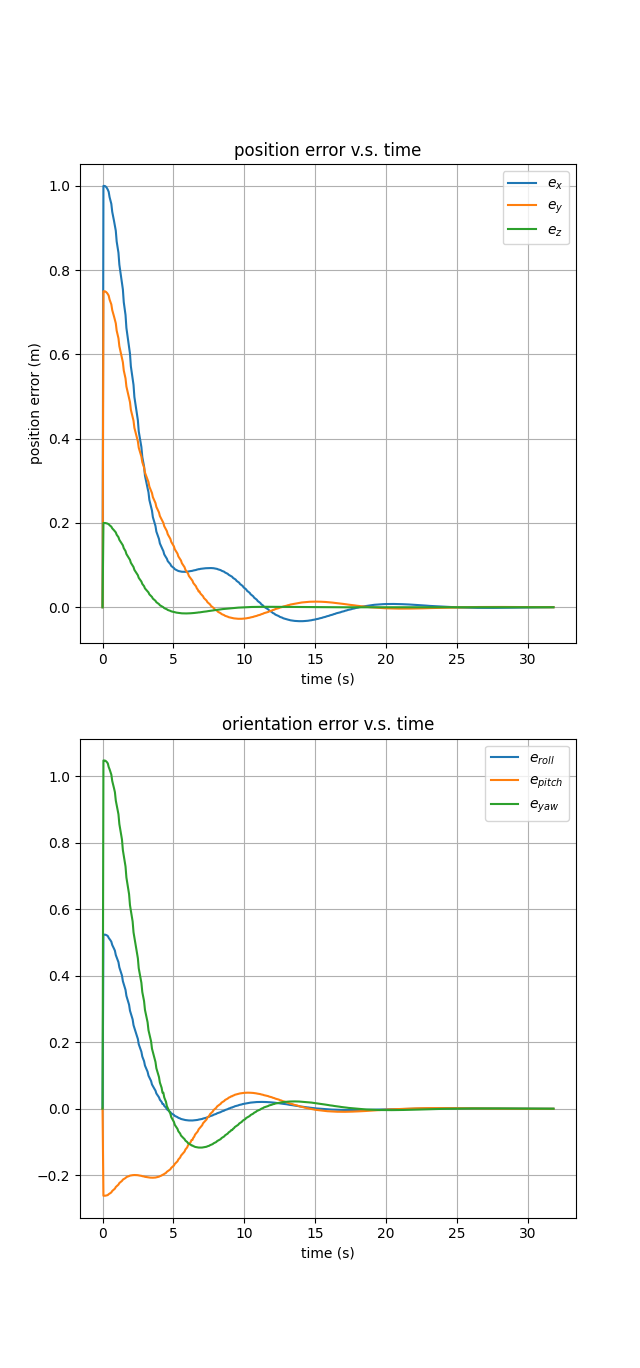